# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

In [7]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'rice_export_amount', 'inflation', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'w

# Model

In [9]:
# Create the target
y = df['nonglu_price']

xvars_water_fertilizer = [
                        'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6', 
                        'sirikit_water', 'bhumibol_water',
                        'water_station_B10','water_station_C13', 'water_station_C2', 'water_station_G8',
                        'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
                        'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
                        'water_station_M6A', 'water_station_M7', 'water_station_N1',
                        'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
                        'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
                        'water_station_Y17', 'water_station_Y1C']

# Adjust X to match the same periods
X = df[xvars_water_fertilizer]

In [10]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 29), (25, 29), (201,), (25,))

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [13]:
label = 'nonglu_price'
df = df[xvars_water_fertilizer + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [14]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 29), (25, 29), (201,), (25,))

In [16]:
# Prediction
y_pred = lr.predict(X_test)

In [17]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 3367581.3220
Linear Regression Model RMSE: 1835.0971
Linear Regression Model R-squared: -2.0621


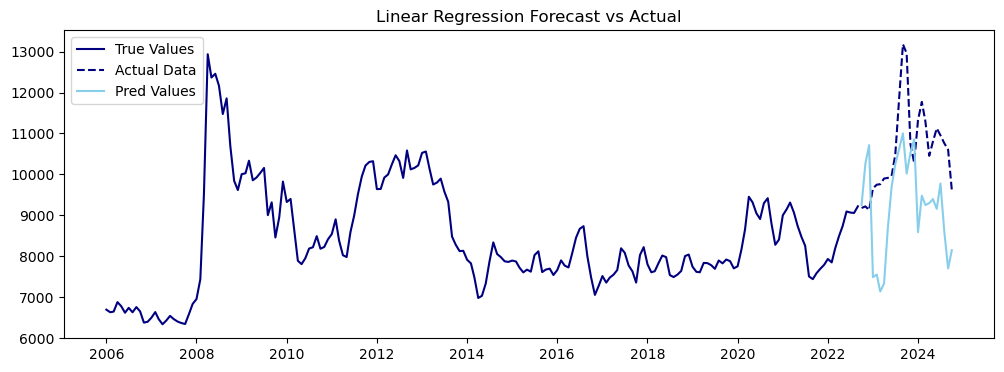

In [18]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/water_fertilizer/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [20]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,fertilizer_1,-0.179881
1,fertilizer_2,-0.090921
2,fertilizer_3,0.459889
3,fertilizer_4,0.255558
4,fertilizer_5,0.000231
5,fertilizer_6,-0.167053
6,sirikit_water,1.376290
7,bhumibol_water,0.223115
8,water_station_B10,-7.388088
9,water_station_C13,0.079250


## 2. ARIMA Model

### Model 2 : ARIMA

In [23]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [25]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 2362278.1051
ARIMAX(2,1,2) Model RMSE :1536.9704
ARIMAX(2,1,2) Model R-squared :-1.1480


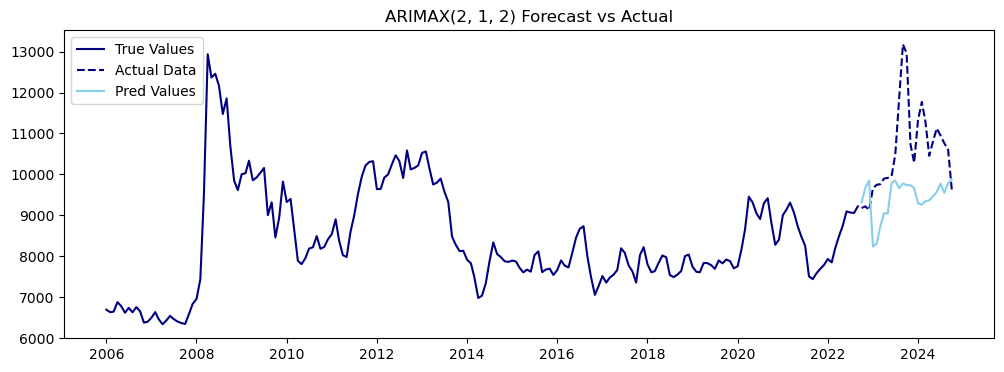

In [26]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure//water_fertilizer/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [28]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1468.482
Date:                Thu, 19 Dec 2024   AIC                           3004.964
Time:                        14:21:46   BIC                           3117.107
Sample:                    01-01-2006   HQIC                          3050.347
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
fertilizer_1           -0.0163      0.109     -0.150      0.881      -0.230       0.197
fertilizer_2           -0.0729      0.080     -0.909      0.363      -0.230       0.084
fertilizer_3           -0.0550      0.102     -0.541      0.588      -0.254       0.144
fertilizer_4           -0.0031      0.066     -0.046      0.963      -0.133       0.127
fertilizer_5            0.1829      0.094      1.939      0.052      -0.002       0.368
fertilizer_6            0.1088      0.069      1.569      0.117      -0.027       0.245
sirikit_water           1.0263      0.660      1.554      0.120      -0.268       2.320
bhumibol_water         -0.2470      0.215     -1.151      0.250      -0.668       0.174
water_station_B10       0.0180      1.651      0.011      0.991      -3.219       3.255
water_station_C13      -0.1136      0.132     -0.863      0.388      -0.372       0.145
water_station_C2        0.2220      0.191      1.162      0.245      -0.152       0.597
water_station_G8       -0.8798      1.887     -0.466      0.641      -4.578       2.818
water_station_K10      -0.2185      0.319     -0.685      0.493      -0.843       0.407
water_station_K11A      0.1150      0.252      0.456      0.648      -0.379       0.609
water_station_Kgt3      0.0870      0.283      0.308      0.758      -0.467       0.641
water_station_Kh103     2.1246      2.784      0.763      0.445      -3.332       7.581
water_station_Kh58A    -0.6257      0.566     -1.105      0.269      -1.736       0.484
water_station_Kh72     -0.9207      3.751     -0.245      0.806      -8.272       6.430
water_station_M6A      -0.0719      0.210     -0.343      0.732      -0.483       0.339
water_station_M7       -0.0681      0.071     -0.954      0.340      -0.208       0.072
water_station_N1       -1.5098      0.894     -1.688      0.091      -3.263       0.243
water_station_N67       0.1753      0.216      0.813      0.416      -0.248       0.598
water_station_Ny1B     -0.6795      1.787     -0.380      0.704      -4.182       2.823
water_station_P1        2.0713      1.725      1.201      0.230      -1.310       5.453
water_station_P17      -0.0814      0.212     -0.384      0.701      -0.497       0.334
water_station_S4B       0.6409      1.686      0.380      0.704      -2.664       3.946
water_station_Sw5A      0.2438      1.142      0.214      0.831      -1.994       2.481
water_station_Y17      -0.4049      0.432     -0.937      0.349      -1.252       0.442
water_station_Y1C      -0.4289      0.476     -0.902      0.367      -1.361       0.503
ar.L1                   0.4501      0.321      1.402      0.161      -0.179       1.079
ar.L2                  -0.5632      0.209     -2.696      0.007      -0.973      -0.154
ma.L1                  -0.1203      0.301     -0.400      0.689      -0.710       0.470
ma.L2                   0.5529      0.229      2.417      0.016       0.105       1.001
sigma2               1.501e+05   1.56e+04      9.601      0.000    1.19e+

### Model 3 : Auto ARIMA

In [30]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        14:21:47   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [31]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 1784460.8375
ARIMAX(2,0,0) Model RMSE :1335.8371
ARIMAX(2,0,0) Model R-squared :-0.6226


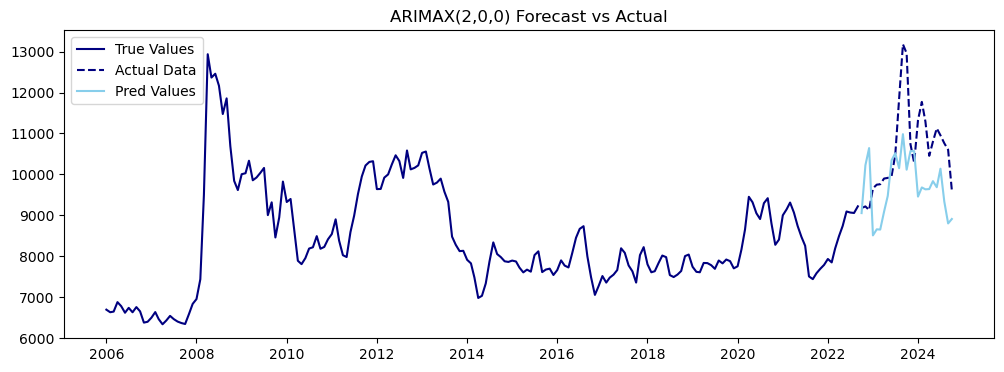

In [33]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/water_fertilizer/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [35]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1514.444
Date:                Thu, 19 Dec 2024   AIC                           3094.888
Time:                        14:21:49   BIC                           3203.897
Sample:                    01-01-2006   HQIC                          3138.998
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4094.5207   1485.293      2.757      0.006    1183.400    7005.641
fertilizer_1           -0.0402      0.180     -0.223      0.823      -0.393       0.313
fertilizer_2           -0.0656      0.120     -0.546      0.585      -0.301       0.170
fertilizer_3            0.0748      0.177      0.423      0.672      -0.272       0.421
fertilizer_4            0.0419      0.105      0.399      0.690      -0.164       0.248
fertilizer_5            0.1288      0.162      0.795      0.426      -0.189       0.446
fertilizer_6            0.0809      0.121      0.671      0.502      -0.155       0.317
sirikit_water           0.8260      1.005      0.822      0.411      -1.144       2.796
bhumibol_water         -0.1739      0.386     -0.451      0.652      -0.930       0.582
water_station_B10      -4.7221      1.705     -2.770      0.006      -8.064      -1.380
water_station_C13      -0.2316      0.234     -0.990      0.322      -0.690       0.227
water_station_C2        0.3576      0.341      1.048      0.294      -0.311       1.026
water_station_G8        3.5456      2.997      1.183      0.237      -2.329       9.420
water_station_K10       0.0197      0.487      0.040      0.968      -0.935       0.974
water_station_K11A      0.4598      0.396      1.161      0.246      -0.316       1.236
water_station_Kgt3      0.1942      0.450      0.432      0.666      -0.687       1.075
water_station_Kh103     3.4389      5.069      0.678      0.498      -6.497      13.375
water_station_Kh58A    -0.9622      1.041     -0.924      0.355      -3.003       1.079
water_station_Kh72    -14.0707      5.986     -2.350      0.019     -25.804      -2.338
water_station_M6A      -0.1892      0.261     -0.726      0.468      -0.700       0.321
water_station_M7       -0.0572      0.092     -0.620      0.535      -0.238       0.124
water_station_N1       -1.4901      1.328     -1.122      0.262      -4.093       1.113
water_station_N67       0.1912      0.293      0.652      0.515      -0.384       0.766
water_station_Ny1B     -0.5309      2.652     -0.200      0.841      -5.729       4.667
water_station_P1       -1.6452      2.292     -0.718      0.473      -6.137       2.847
water_station_P17      -0.2824      0.369     -0.766      0.444      -1.005       0.441
water_station_S4B       1.0703      2.523      0.424      0.671      -3.875       6.016
water_station_Sw5A      1.4686      1.625      0.904      0.366      -1.716       4.653
water_station_Y17      -0.0343      0.595     -0.058      0.954      -1.201       1.133
water_station_Y1C      -0.1696      0.823     -0.206      0.837      -1.782       1.443
ar.L1                   1.0615      0.128      8.274      0.000       0.810       1.313
ar.L2                  -0.2634      0.132     -1.992      0.046      -0.523      -0.004
sigma2               2.944e+05   4.69e+04      6.272      0.000    2.02e+05    3.86e+05
=========================================================================

## 4. GARCH Model

### Model 4 : GARCH

In [38]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [39]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 1224188.4536
GARCH Model RMSE :1106.4305
GARCH Model R-squared :-0.1132


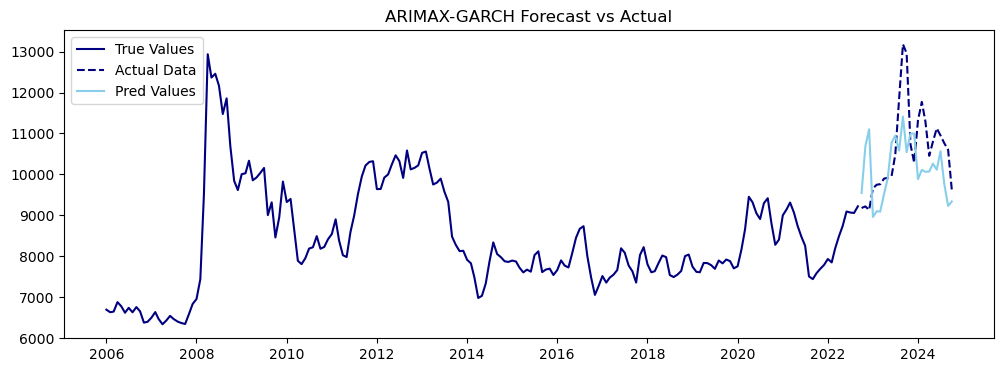

In [40]:
# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/water_fertilizer/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [42]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 56032.13306676877
alpha (ARCH term): 0.22725699585562967
beta (GARCH term): 0.4664823305893246


# Compare the score of models

In [44]:
score_df = pd.DataFrame(data = {'feature' : ['water and fertilizer'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/water_fertilizer.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,water and fertilizer,Linear,3.367581e+06,1835.097088,-2.062137
1,water and fertilizer,"ARIMAX(2,0,0)",1.784461e+06,1335.837130,-0.622608
2,water and fertilizer,GARCH,1.224188e+06,1106.430501,-0.113153
